In [234]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
sns.set_style('white')
%matplotlib inline

# Auxiliary tutorial 7: Support vector machines

## Face recognition with SVMs

Now we will train an SVM classifier to recognize faces. We will use images from [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/), a huge database of labeled face photographs that is available through the sklearn.datasets module. The script is based on [this example](http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html) from the sklearn documentation.

Let's get started and fetch some photographs. To get a decent predictive power, we will only use those of people for which there are at least 50 pictures available.

In [235]:
# fetch photographs from the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=50)
# get number of pictures and dimensions
n_samples, h, w = lfw_people.images.shape
# get the names of people in the picture, in case we can't recognize them...
names = lfw_people.target_names
n_people = names.shape[0]

Let's see how many people and pictures we found that meet our requirement.

In [236]:
print("""
    There are {0} people with more than 50 pictures, and a total of {1} photographs.
    Each one is a grayscale image of {2} by {3} pixels.
    """.format(n_people, n_samples, h, w))


    There are 12 people with more than 50 pictures, and a total of 1560 photographs.
    Each one is a grayscale image of 62 by 47 pixels.
    


Since we will be looking at several pictures throughout the tutorial, we will define a function to plot a gallery of pictures.

In [247]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4, fig_title=None):
    """
    Helper function to plot a gallery of portraits
    """
    fig = plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        ax = fig.add_subplot(n_row, n_col, i + 1)
        ax.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        ax.set_title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    if fig_title: fig.suptitle(fig_title+'\n', fontsize=20)

Now we can take a look at one picture of each person and see if we can recognize anyone.

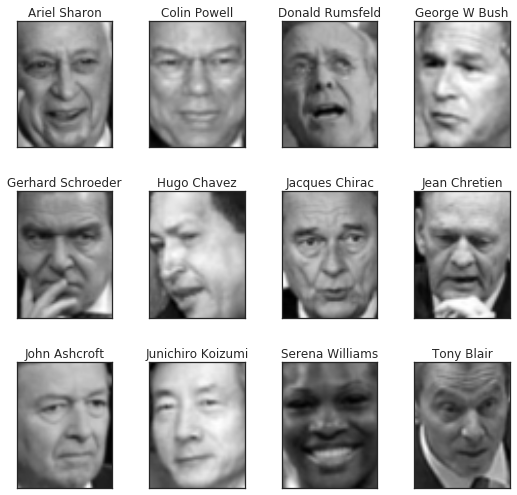

In [248]:
# get the index of one picture of each person
unique_pic = [np.where(lfw_people.target==n)[0][0] for n in np.arange(12)]
# look at them
plot_gallery(lfw_people.images[unique_pic], names, h, w)

Mostly politicians, all  with wikipedia pages if you'd like to know who they are.

We will ignore relative pixel position and treat each photograph as a $62 \times 47 = 2914$ dimensional datapoint. So we need to get our data into a 2914 dimensional array, instead of the 62 by 47 pixels that we have. We can access data in this form directly from the loader, so we will just do that. 

Also, we are trying to use SVM for face recognition, so we need to split our data into a training and a test set to see how we are doing. We will use sklearn's handy train_test_split function for this.

In [239]:
# get images as n dimensional array
photos = lfw_people.data
print("""
    There are still {0} images, now each represented as a {1}
    dimensional array.""".format(*photos.shape))

# get the labels of each photograph
labels = lfw_people.target
# split into a training and testing set
photos_train, photos_test, labels_train, labels_test = train_test_split(
    photos, labels, test_size=0.25, random_state=42)


    There are still 1560 images, now each represented as a 2914
    dimensional array.


Training an SVM using datapoints of 2914 dimensions will probably take a while. And we can see in the photographs that many of those points (pixels) are pretty similar (e.g. the face skin of each person is made up by roughly the same color). So we probably don't need all those dimensions. What can we do to get rid of features that would not contribute very much to tell faces apart? i.e. how do we reduce the number of dimensions while preserving the variance? A pretty good answer is: principal component analysis. You can read the [excellent tutorial](http://bebi103.caltech.edu/2016/tutorials/aux4_pca.html) about PCA if you haven't yet. So let's get rid of some dimensions; we will start with 10% of the original number and figure out how many we need.

In [240]:
# 10% of the dimensions
n_components = int(photos.shape[1] * 0.1)
# apply dimensionality reduction
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(photos_train)

We can tell how much each new feature contributes to making the photographs different by computing their explained variance ratio. We can also get an idea of how many dimensions we need by looking at at the cumulative explained variance as we increase the number of dimensions/features. Let's do that.

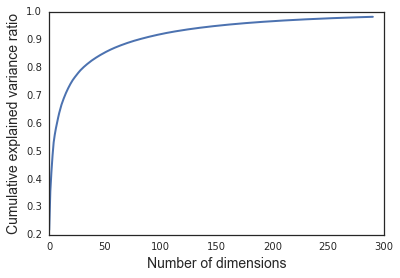

In [241]:
# compute cumulative sum of explained variance ratios
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)
# look at it
plt.plot(cum_exp_var)
plt.xlabel('Number of dimensions')
plt.ylabel('Cumulative explained variance ratio')

It seems like indeed we don't need that many dimensions. We'll go with 50 for now, which should get us about 80% of the variance.

In [242]:
n_components = 50
# apply dimensionality reduction
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(photos_train)
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

print("""
    {0} features explain {1:.2f}% of the variance.
    """.format(n_components, cum_exp_var[-1]*100))

# Project the data to the lower dimensional planes
photos_train_pca = pca.transform(photos_train)
photos_test_pca = pca.transform(photos_test)


    50 features explain 85.15% of the variance.
    


We can see what these components look like by reshaping them back into photographs to get "eigenfaces".

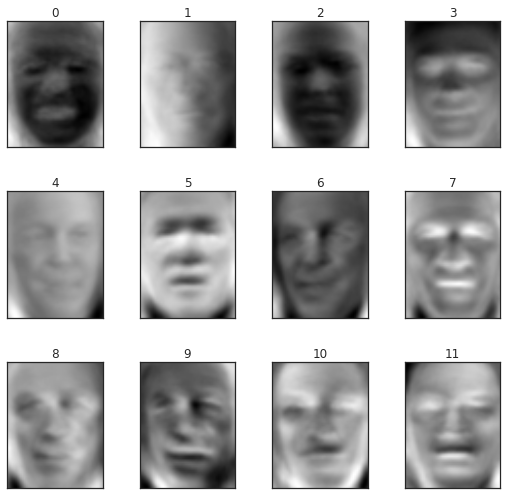

In [243]:
# get the eigenfaces
eigenfaces = pca.components_.reshape((n_components, h, w))
# number them for plot
n_eigenfaces = np.arange(eigenfaces.shape[0])
plot_gallery(eigenfaces, n_eigenfaces, h, w)

So these are the features that (mostly) make the faces in our photographs different. 

We are now all set to train our SVM classifier. We will use an rbf kernel; to figure out the best parameters we will explore a range using the GridSearchCV function of sklearn.

In [244]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(photos_train_pca, labels_train)

That's it! We've trained our SVM to recognize faces. To see how we are doing, we will use the classifier to label our test photographs. It is important that we don't test our classifier on the training set, as that will overestimate our predictive ability. We will also show one picture of each predicted person for our reference.

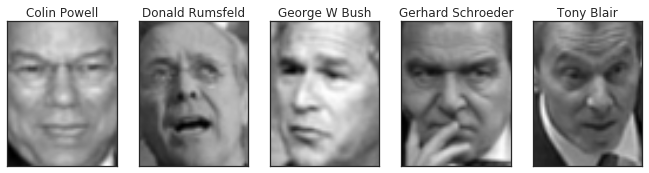

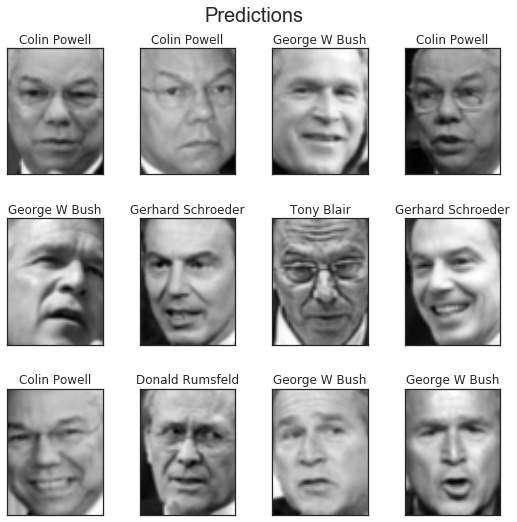

In [249]:
np.random.seed(10)
# predict labels of our test set
labels_pred = clf.predict(photos_test_pca)
# get indices to randomly look at our predictions
r_ind = np.random.choice(photos_test.shape[0], size=12, replace=False)

# get pictures and respective predictions to look at
s_photos = photos_test[r_ind]
labels_pred_sample = labels_pred[r_ind]
names_pred = names[labels_pred_sample]

# get labels and photos of each person for reference
labels_unique = np.unique(labels_pred_sample)
names_true = names[labels_unique]
photos_true = [np.where(lfw_people.target==n)[0][0] for n in labels_unique]
n_col = len(photos_true)
# plot one picture of each person predicted and shown
plot_gallery(lfw_people.images[photos_true], names_true, h, w, 
             n_row=1, n_col=n_col)
# uncomment to plot pictures of everyone instead
#plot_gallery(lfw_people.images[unique_pic], names, h, w)

# plot predictions
plot_gallery(s_photos, names_pred, h, w, n_row=3, n_col=4, fig_title="Predictions")

Not too bad for only having used 50 features (out of the original 2914).

We can also be more quantitative and get some numbers using the handy classification report function. 

In [250]:
print(classification_report(labels_test, labels_pred, target_names=names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.68      0.81      0.74        16
     Colin Powell       0.85      0.88      0.87        66
  Donald Rumsfeld       0.58      0.67      0.62        27
    George W Bush       0.88      0.88      0.88       140
Gerhard Schroeder       0.44      0.46      0.45        24
      Hugo Chavez       0.87      0.76      0.81        17
   Jacques Chirac       0.67      0.40      0.50        10
    Jean Chretien       0.86      0.86      0.86        14
    John Ashcroft       0.70      0.88      0.78        16
Junichiro Koizumi       1.00      0.73      0.84        11
  Serena Williams       0.86      0.67      0.75         9
       Tony Blair       0.76      0.72      0.74        40

      avg / total       0.80      0.79      0.79       390

